In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

C:\Users\klaes\AppData\Local\Temp\ipykernel_2532\1500862777.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

  import dask.dataframe as dd


In [3]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [4]:
df.sample(n = 5)
# n -> number of rows
# frac = 0.01 -> get 1% of the data set
# random_state = 10 -> fixed the random state having allways the same sample


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
645859,REG,2012-08-01,47.970001,49.200001,47.77,48.639999,31.190165,1066500,Real Estate,Retail REITs,2012,47.849998,0.016510,1,1.0
753734,PG,2006-10-17,61.790001,62.480000,61.77,62.250000,37.502850,6684000,Consumer Staples,Personal Care Products,2006,62.049999,0.003223,1,1.0
914656,KR,2020-01-13,28.340000,28.709999,28.25,28.420000,25.816574,3796000,Consumer Staples,Food Retail,2020,28.360001,0.002116,1,1.0
1926802,JBL,2015-11-20,24.700001,25.219999,24.67,25.209999,23.369980,2796400,Information Technology,Electronic Manufacturing Services,2015,24.629999,0.023549,1,1.0
2431002,CHRW,2015-09-28,68.730003,69.440002,67.82,67.860001,54.748058,1758900,Industrials,Air Freight & Logistics,2015,68.529999,-0.009777,0,1.0


In [5]:
# select_tickers = df['ticker'].unique().tolist()[0:9]
select_tickers = ['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']
select_tickers

['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']

In [7]:
idx = df['ticker'].isin(select_tickers)
small_df = df[idx]
simple_sample_dt = small_df.sample(frac = 0.1)

simple_sample_dt.shape, small_df.shape

((5432, 15), (54317, 15))

Look at the distribution of tickers.

In [9]:
small_df['ticker'].value_counts()

ticker
D       6159
AMT     6159
PWR     6159
ROK     6159
OXY     6159
TXN     6159
YUM     6159
PCG     6159
CBRE    5045
Name: count, dtype: int64[pyarrow]

<Axes: xlabel='ticker'>

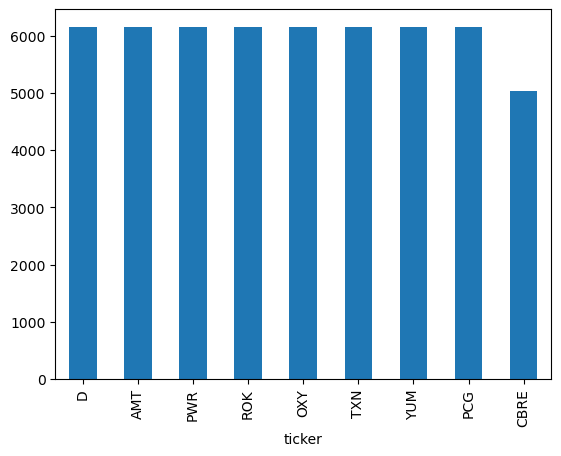

In [8]:
# original population looks like the graphic below
small_df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

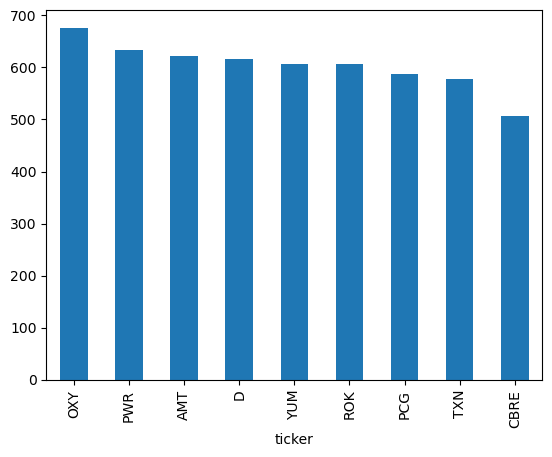

In [10]:
# the data frame below no longer loos like the original population ... so this is not good
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

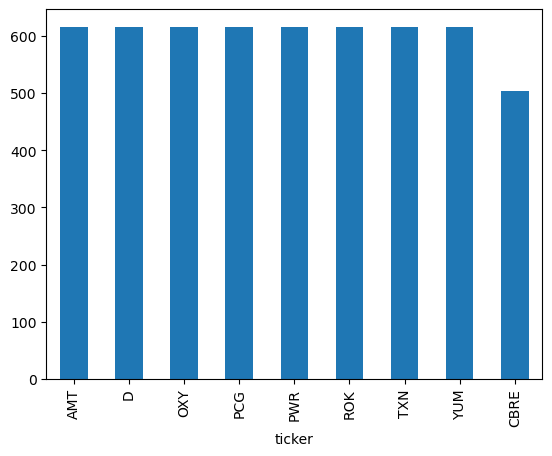

In [12]:
# now the distribution looks like the orignal population ... 
# the code below implements the stratified sampling

strat_sample_dt = small_df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

C:\Users\klaes\AppData\Local\Temp\ipykernel_2532\2932236319.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd_dt = (dd_dt


<Axes: xlabel='ticker'>

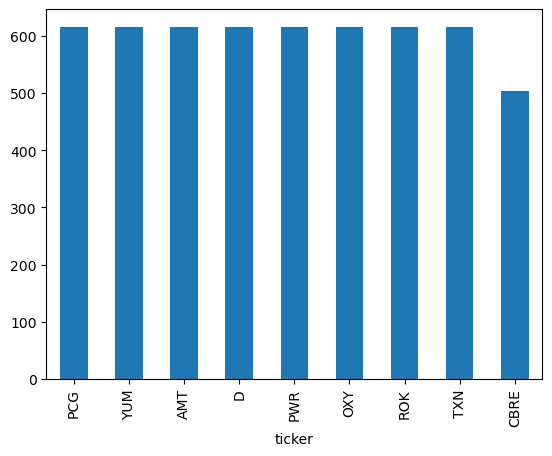

In [13]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd_dt[strat_sample_dd_dt['ticker'].isin(select_tickers)]['ticker'].value_counts().plot(kind='bar')